# Mini Time Series Project - AVG Temperature Prediction Greenland

    ### Robert Murphy
    ### 7/8/2021

--------

# Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import explore

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Pre-Planning:

#### 1.) Basic MVP notebook.

#### 2.) Run through the entire DS pipeline similar to time series exercise.

#### 3.) Investigate the dataset and see if there is any missing values and deicide what to do with those values.

#### 4.) Date needs to become the index and if not a datatime datatype needs to be changed.

#### 5.) Split the data into train, validate, test.

#### 6.) Forecast utilizing: last observed, simple average, moving average, Holts linear trend.

#### 7.) Compare actual vs prediction and see which rmse is lowest.

#### 8.) Evaluate on test.

-----

# Dataset Info:

- Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
- LandAverageTemperature: global average land temperature in celsius
- LandAverageTemperatureUncertainty: the 95% confidence interval around the average
- LandMaxTemperature: global average maximum land temperature in celsius
- LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature
- LandMinTemperature: global average minimum land temperature in celsius
- LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature
- LandAndOceanAverageTemperature: global average land and ocean temperature in celsius
- LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

------

# Wrangle:

In [2]:
#importing csv and creating a DataFrame.
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df.head(100)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
95,1751-10-01,NaN,NaN,Åland
96,1751-11-01,NaN,NaN,Åland
97,1751-12-01,NaN,NaN,Åland
98,1752-01-01,-4.633,2.852,Åland


In [4]:
#will focus on greenland
df = df[df.Country == 'Greenland']


In [5]:
#shape of df is 2289 records x 3 fields
df.shape

(2289, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 209895 to 212183
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2289 non-null   object 
 1   AverageTemperature             2288 non-null   float64
 2   AverageTemperatureUncertainty  2288 non-null   float64
 3   Country                        2289 non-null   object 
dtypes: float64(2), object(2)
memory usage: 89.4+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,2288.0,-18.587458,10.850606,-37.658,-28.56125,-21.2645,-6.69425,0.339
AverageTemperatureUncertainty,2288.0,1.822842,1.032897,0.358,0.93600,1.5925,2.80925,8.425


In [8]:
#looking into percentage of nans
df.isna().sum()/len(df)

dt                               0.000000
AverageTemperature               0.000437
AverageTemperatureUncertainty    0.000437
Country                          0.000000
dtype: float64

### Main Takeaways:
- 1.) Need to change temperature to Farenheight.
- 2.) rename dt to date, 
- 3.) will focus on Greenland.
- 4.) Alot of the temperatures in greenland are negative.

 -------

# Prepare:

## Goals:

- 1.) Convert Temp to Faren from celsius. Rename to shorter.
- 2.) Temperatures need to be rounded to two decimal places(hundreth).
- 3.) Can remove the Country Column, know I am working just with greenland.
- 4.) change date to datetime from object.
- 5.) Set index to date and sort.
- 6.) Feel comfortable dropping Nans.
- 7.) Find outliers and figure out what to do with them.


In [9]:
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

In [10]:
#renaming temp to shorten column names
df.rename(columns = {'dt': 'date', 'AverageTemperature': 'avg_temp', 'AverageTemperatureUncertainty':'avg_temp_uncer' },inplace = True)

In [11]:
#dropping column country since its just greenland.
df.drop(columns = ['Country', 'avg_temp_uncer'],inplace = True)

In [12]:
#converting to faren
df['avg_temp'] = round(df['avg_temp'] * 9/5 + 32,2)

In [13]:
df.head(10)

,date,avg_temp
209895,1823-01-01,-21.86
209896,1823-02-01,-26.27
209897,1823-03-01,-20.32
209898,1823-04-01,-7.66
209899,1823-05-01,7.86
209900,1823-06-01,24.87
209901,1823-07-01,29.90
209902,1823-08-01,23.32
209903,1823-09-01,9.03
209904,1823-10-01,-7.52


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 209895 to 212183
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2289 non-null   object 
 1   avg_temp  2288 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.6+ KB


In [15]:
#will just drop nulls
df.dropna(inplace = True)

In [16]:
#new shape 2288 records x 3 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 209895 to 212182
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2288 non-null   object 
 1   avg_temp  2288 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.6+ KB


In [17]:
#converting date to datetime type. Removing Leap year
df['date'] = pd.to_datetime(df.date).sort_values()
df = df[~((df.date.dt.month == 2) & (df.date.dt.day == 29))]

In [18]:
# set index
df = df.set_index('date')

In [19]:
# filtering to dates from 1940 and on.
df =df.loc['1940-01-01':]

In [20]:
print('Data ranges from {} to {}'.format(df.index.min(), df.index.max()))

Data ranges from 1940-01-01 00:00:00 to 2013-08-01 00:00:00


In [21]:
# aggregate or resample daily by summing average temp
df = df.resample('3M')[['avg_temp']].sum()
# remove leap day


In [22]:
print('Data ranges from {} to {}'.format(df.index.min(), df.index.max()))

Data ranges from 1940-01-31 00:00:00 to 2013-10-31 00:00:00


<AxesSubplot:xlabel='date'>

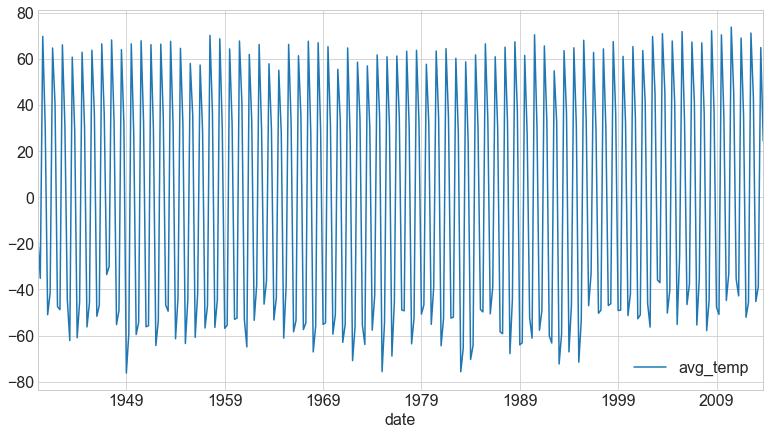

In [23]:
df.plot()

## Splitting the Data

In [24]:
# train will be half the df
train_size = int(len(df) * 0.5)
train_size 

148

In [25]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

88

In [26]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

60

In [27]:
#specifying the validate end point, have to do this to specifiy number at which validate ends so can specify test.
validate_end_index = train_size + validate_size
validate_end_index

236

In [28]:
# train will go from 0 to 95
train = df[:train_size]
# validate will go from 96 to 153
validate = df[train_size:validate_end_index]
# test will include 154 to end
test = df[validate_end_index:]

## Split Verification:

In [29]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [30]:
# is record for beginning of df same as train.
print(df.head(1) == train.head(1))

            avg_temp
date                
1940-01-31      True


In [31]:
#Train end and validate start are different
pd.concat([train.tail(1), validate.head(1)])

,avg_temp
date,
1976-10-31,34.83
1977-01-31,-48.90


In [32]:
# validate end and test start different
pd.concat([validate.tail(1), test.head(1)])

,avg_temp
date,
1998-10-31,36.25
1999-01-31,-49.11


In [33]:
#end of test and df the same, yes
pd.concat([test.tail(1), df.tail(1)])

,avg_temp
date,
2013-10-31,24.4
2013-10-31,24.4


In [34]:
# so split was successful!

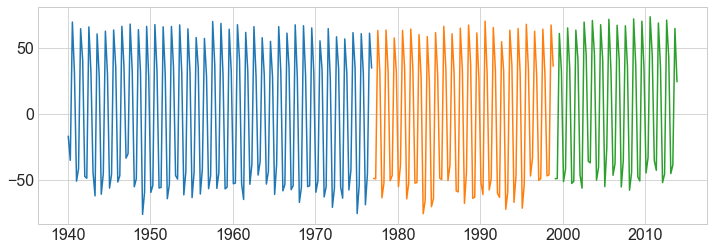

In [35]:
#plotting train validate, test.
plt.figure(figsize=(12,4))
plt.plot(train)
plt.plot(validate)
plt.plot(test)

### Main Takeaways:

#### - 1.) Dropped NANs and  the columns Country and temp uncer. Know this is Greenland and temp uncer wont be utilized.
#### - 2.) Sorted Date and set the index to date.
#### - 3.) Resampled(GROUP BY) Year and sum the avg temp for the year.
#### - 4.) Split the data into a train, validate and test set.

-----

# Explore:

## Goal:

- ### Look for trends in temp over time. 

In [36]:
y = train.avg_temp

In [ ]:
# Univariate exploration of Target

<AxesSubplot:ylabel='Frequency'>

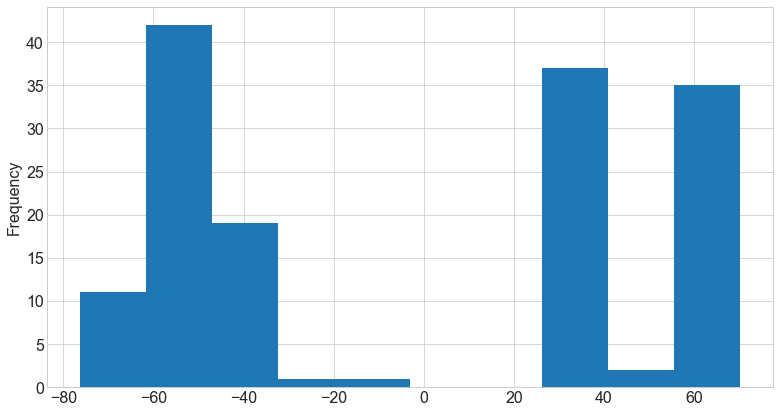

In [37]:
y.plot.hist()

[Text(0.5, 1.0, 'Sum Avg temp by 6Months'),
 Text(0.5, 0, 'year'),
 Text(0, 0.5, 'avg_temp')]

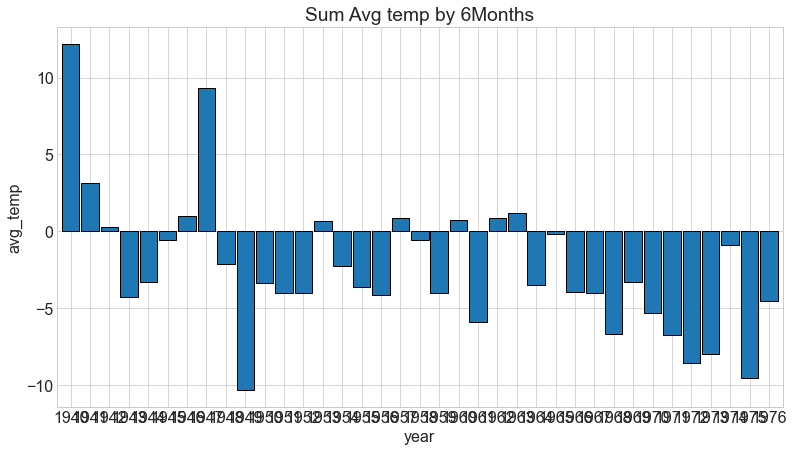

In [38]:
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0,)
ax.set(title='Sum Avg temp by 6Months', xlabel='year', ylabel='avg_temp')

## Auto_Correlation 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

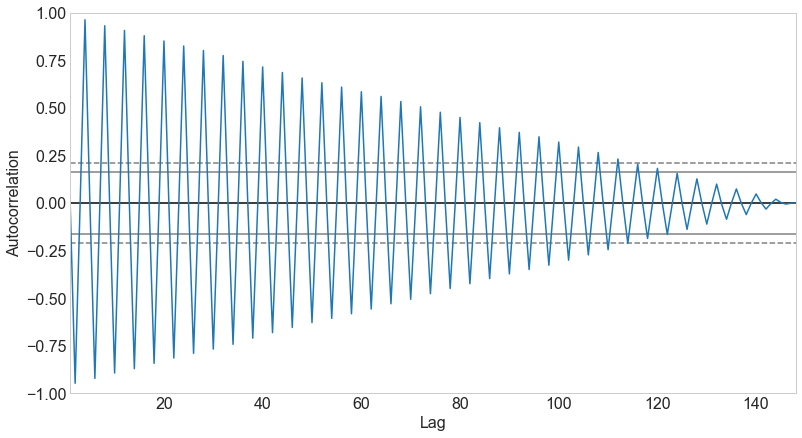

In [39]:
pd.plotting.autocorrelation_plot(train.avg_temp)

## Decomposition

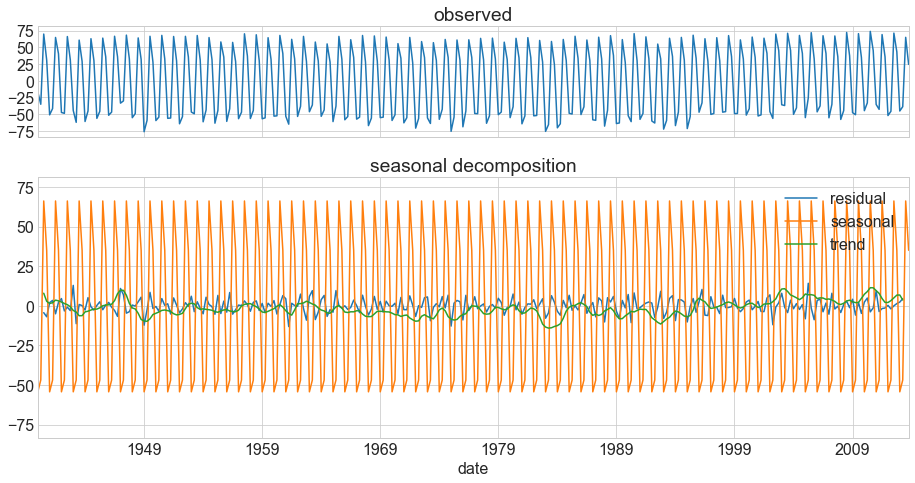

In [40]:
result = sm.tsa.seasonal_decompose(df, model='additive')
result = pd.DataFrame(dict(
    observed=result.observed,
    residual=result.resid,
    seasonal=result.seasonal,
    trend=result.trend
))
gs = plt.GridSpec(3, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[1:])
ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
result.iloc[:, 1:].loc['1940':].plot(ax=ax1, title='seasonal decomposition')
result.observed.loc['1940':].plot(ax=ax2, title='observed')
fig.tight_layout()

<AxesSubplot:xlabel='date'>

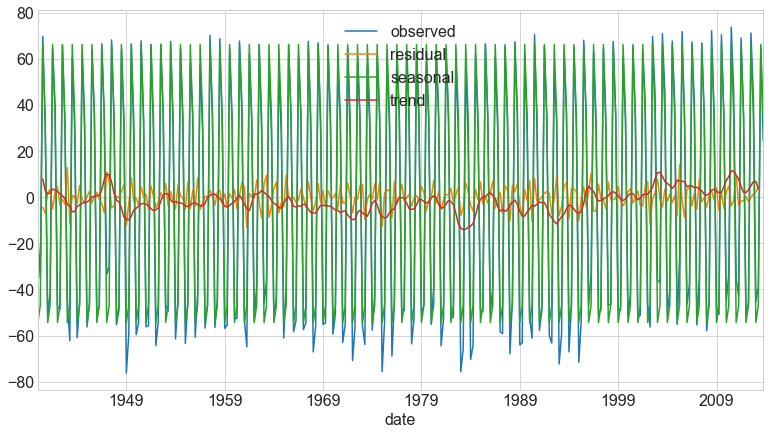

In [41]:
result.plot()

## Categories over time

In [42]:
train['temp_bin'] = pd.qcut(train.avg_temp, 3, labels=['cold', 'cool' , 'hot'])
train.groupby('temp_bin',).mean()

,avg_temp
temp_bin,
cold,-58.072400
cool,-4.810816
hot,56.971837


Text(0, 0.5, '% of months in the year')

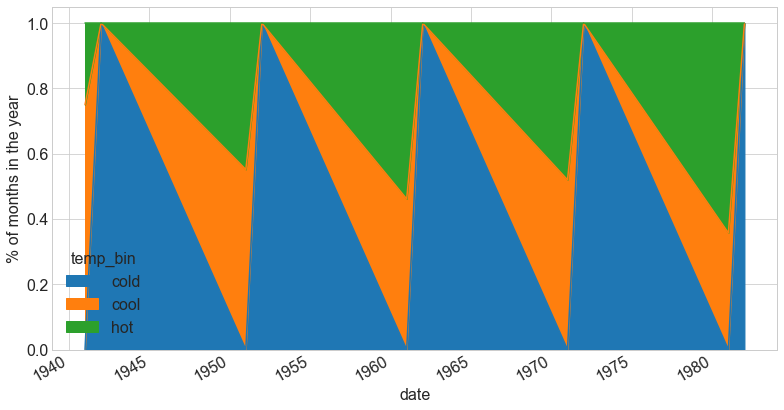

In [43]:
(train.groupby('temp_bin')
 .resample('10Y')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of months in the year')

In [44]:
train.drop(columns = 'temp_bin', inplace = True)

### Main Takeaways:

#### - 1.) Unsure of what to make of charts recommend more investigation into concepts.

---------

# Forecasting

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Avg_temp

In [45]:
# take the last item of avg_temp and assign to variable
temp = round(train['avg_temp'][-1:][0], 2)
temp

34.83

In [46]:
yhat_df = pd.DataFrame({'avg_temp': [temp]}, 
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1977-01-31,34.83
1977-04-30,34.83
1977-07-31,34.83
1977-10-31,34.83
1978-01-31,34.83


In [47]:
yhat_df.describe()

,avg_temp
count,8.800000e+01
mean,3.483000e+01
std,4.287688e-14
min,3.483000e+01
25%,3.483000e+01
50%,3.483000e+01
75%,3.483000e+01
max,3.483000e+01


### **Plot Actual vs. Predicted Values**



In [48]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [49]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [50]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

avg_temp -- RMSE: 65.7210


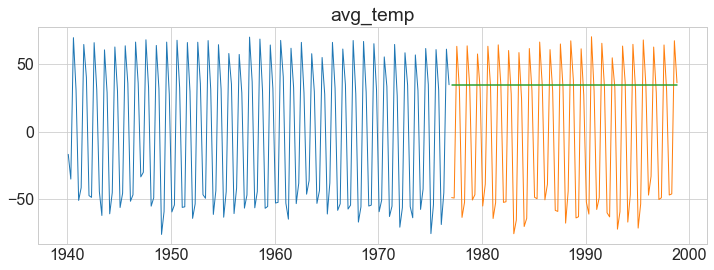

In [51]:
#plotting last observed value model.
plot_and_eval('avg_temp')

In [52]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [53]:
train.head()

,avg_temp
date,
1940-01-31,-16.84
1940-04-30,-35.15
1940-07-31,69.72
1940-10-31,30.96
1941-01-31,-50.95


In [54]:

for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,65.721


### Simple Average


**Make Predictions**

Avg_temp: establishing the value of the prediction we will make

In [55]:
# compute simple average
temp = round(train['avg_temp'].mean(), 4)
temp

-2.3495

In [56]:
def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [temp],
                           },
                          index=validate.index)
    return yhat_df

In [57]:
yhat_df = make_predictions()

In [58]:
yhat_df.head()

,avg_temp
date,
1977-01-31,-2.3495
1977-04-30,-2.3495
1977-07-31,-2.3495
1977-10-31,-2.3495
1978-01-31,-2.3495


In [59]:
yhat_df.describe()

,avg_temp
count,8.800000e+01
mean,-2.349500e+00
std,4.019707e-15
min,-2.349500e+00
25%,-2.349500e+00
50%,-2.349500e+00
75%,-2.349500e+00
max,-2.349500e+00


avg_temp -- RMSE: 53.1742


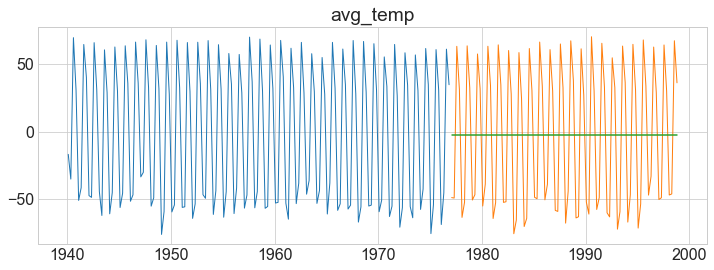

In [60]:
for col in train:
    plot_and_eval('avg_temp')

#### **Evaluate**

Evaluate using MSE and RMSE

In [61]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,65.7210
1,simple_average,avg_temp,53.1742


------

### Moving Average



In [62]:
# demonstrate that the mean of the first 60 days 
# is equal to rolling(60) on day 60

print(train['avg_temp'].rolling(60).mean())


date
1940-01-31         NaN
1940-04-30         NaN
1940-07-31         NaN
1940-10-31         NaN
1941-01-31         NaN
                ...   
1975-10-31   -4.283167
1976-01-31   -4.546833
1976-04-30   -4.220667
1976-07-31   -4.231833
1976-10-31   -4.194667
Freq: 3M, Name: avg_temp, Length: 148, dtype: float64


#### **Predictions**

In [63]:
period = 60

# take 60 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp = round(train['avg_temp'].rolling(period).mean()[-1], 2)
print(temp)

-4.19


In [64]:
yhat_df = make_predictions()
yhat_df.head()

,avg_temp
date,
1977-01-31,-4.19
1977-04-30,-4.19
1977-07-31,-4.19
1977-10-31,-4.19
1978-01-31,-4.19


#### **Plot Actual vs. Predicted Values**

**Moving Average**

avg_temp -- RMSE: 53.1551


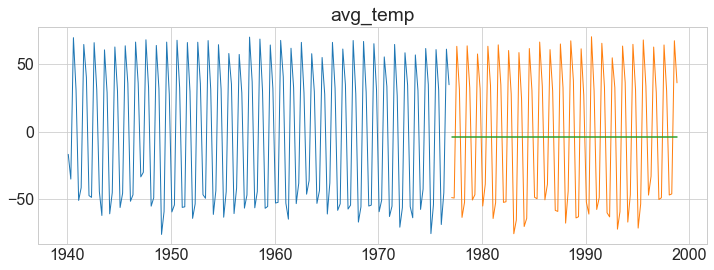

In [65]:
for col in train.columns:
    plot_and_eval(col)

#### **Evaluate**

Evaluate using MSE and RMSE.

In [66]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '60d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,65.7210
1,simple_average,avg_temp,53.1742
2,60d_moving_avg,avg_temp,53.1551


In [67]:
#will look at rolling averages for 10, 30 and 45 days
periods = [10, 30, 45]

for p in periods: 
    avg_temp = round(train['avg_temp'].rolling(p).mean()[-1], 6)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [68]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,65.7210
1,simple_average,avg_temp,53.1742
2,60d_moving_avg,avg_temp,53.1551
3,10d_moving_avg,avg_temp,53.1551
4,30d_moving_avg,avg_temp,53.1551
5,45d_moving_avg,avg_temp,53.1551


In [69]:
#comparison of different time period rmse values
min_avg_temp_rmse = eval_df[eval_df.target_var == 'avg_temp']['rmse'].min()

eval_df[eval_df.rmse == min_avg_temp_rmse]

,model_type,target_var,rmse
2,60d_moving_avg,avg_temp,53.1551
3,10d_moving_avg,avg_temp,53.1551
4,30d_moving_avg,avg_temp,53.1551
5,45d_moving_avg,avg_temp,53.1551


### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

avg_temp 



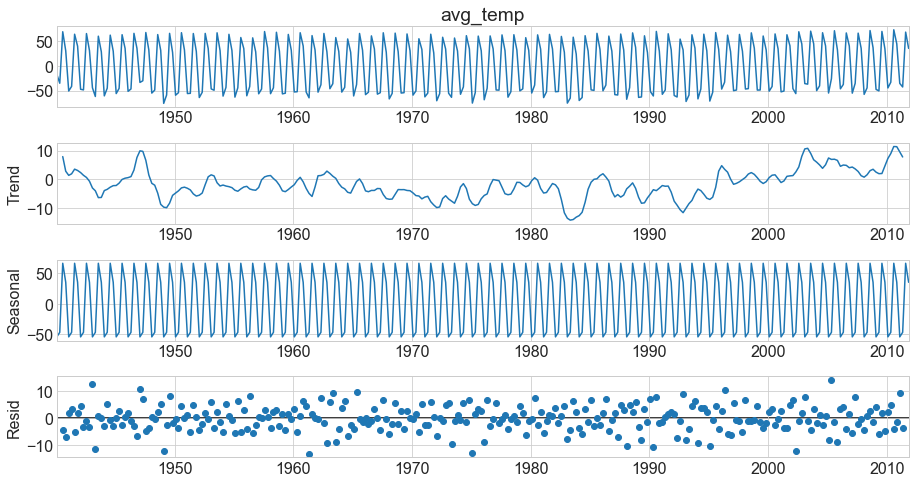

In [126]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
plt.show()

### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [71]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [72]:
col = 'avg_temp'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 4)

In [112]:
yhat_df.head(50)

,avg_temp
date,
2012-01-31,-35.558099
2012-04-30,-42.838099
2012-07-31,68.901901
2012-10-31,35.691901


#### **Plot Actual vs. Predicted Values**

avg_temp -- RMSE: 56.9439


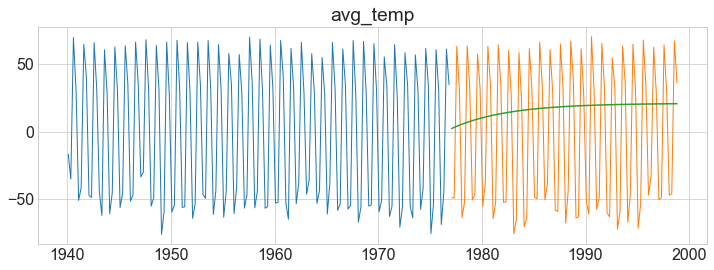

In [73]:
#plotting holt model
for col in train.columns:
    plot_and_eval(target_var = col)

#### **Evaluate**

In [74]:
#adding holt to df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [75]:
#sort by rmse to compare values
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,60d_moving_avg,avg_temp,53.1551
3,10d_moving_avg,avg_temp,53.1551
4,30d_moving_avg,avg_temp,53.1551
5,45d_moving_avg,avg_temp,53.1551
1,simple_average,avg_temp,53.1742
6,holts_optimized,avg_temp,56.9439
0,last_observed_value,avg_temp,65.7210


#### Changing hyperparameters. 


In [76]:
#changing hyperparameter to .1
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope=0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 4)

avg_temp -- RMSE: 61.5335


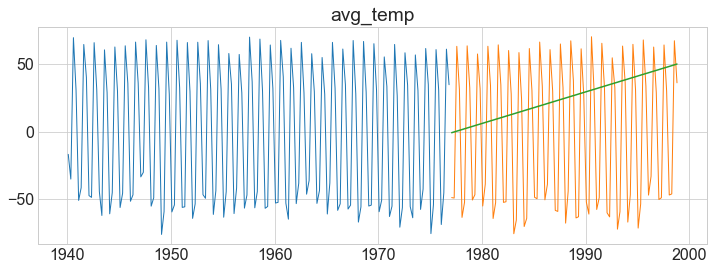

In [77]:
#plotting holt_.1
for col in train.columns:
    plot_and_eval(target_var = col)

In [80]:
#comparing model rmse values
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,60d_moving_avg,avg_temp,53.1551
3,10d_moving_avg,avg_temp,53.1551
4,30d_moving_avg,avg_temp,53.1551
5,45d_moving_avg,avg_temp,53.1551
1,simple_average,avg_temp,53.1742
6,holts_optimized,avg_temp,56.9439
7,holts_.1,avg_temp,61.5335
0,last_observed_value,avg_temp,65.7210


In [ ]:
#Predict on previous cycle

In [89]:
#train is temp 2011 prior
train = df[:'2011']
#validate is 2012 avg temps
validate = df['2012']
#test is 2013 avg temps
test = df['2013']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(288, 1)
(4, 1)
(4, 1)


,avg_temp
date,
2010-10-31,45.07
2011-01-31,-35.48
2011-04-30,-42.76
2011-07-31,68.98
2011-10-31,35.77


#### **Make Predictions**

In [105]:
# finding the year-over-year difference for each day from 2010-2013
yhat_df = train['2011'] + train.diff(4).mean()

In [106]:
#prediction for 2012
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2011-01-31,-35.558099
2012-01-31,-52.030000


In [107]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [108]:
yhat_df.describe()

,avg_temp
count,4.000000
mean,6.549401
std,54.617721
min,-42.838099
25%,-37.378099
50%,0.066901
75%,43.994401
max,68.901901


In [109]:
yhat_df.head()

,avg_temp
date,
2012-01-31,-35.558099
2012-04-30,-42.838099
2012-07-31,68.901901
2012-10-31,35.691901


In [110]:
yhat_df.shape

(4, 1)

#### **Plot and Evaluate**

avg_temp -- RMSE: 9.2186


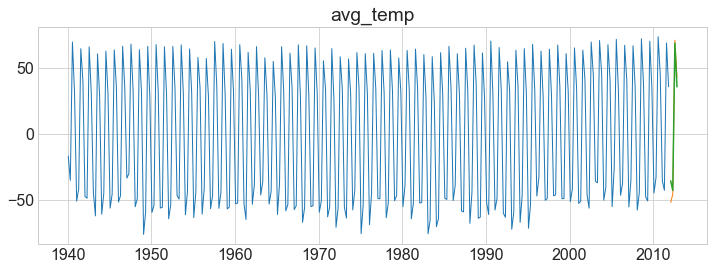

In [111]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

--------

# Conclusion

In [100]:
avg_temp_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]


# find which model that is
eval_df[((eval_df.rmse == avg_temp_min_rmse))]

,model_type,target_var,rmse
8,previous_year,avg_temp,9.2186


In [122]:
yhat_df = validate + train.diff(4).mean()
yhat_df.index = test.index

In [123]:
rmse_temp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)


In [124]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

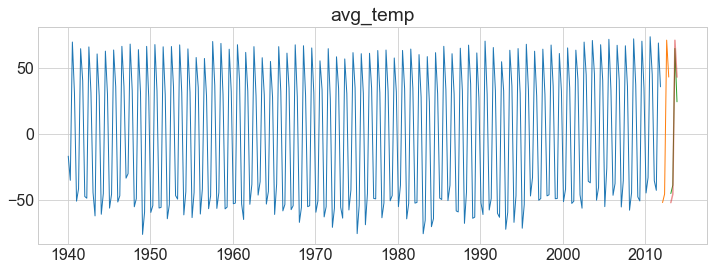

In [125]:
for col in train.columns:
    plot_and_eval(col)

#### Main Takeaways:

#### - The cycle model is the best

----

# Predicting to 2015

In [130]:
#want to predict to 2015 setting prediction
yhat_df = test + train.diff(4).mean()

yhat_df.index = test.index + pd.Timedelta('2Y')

In [131]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

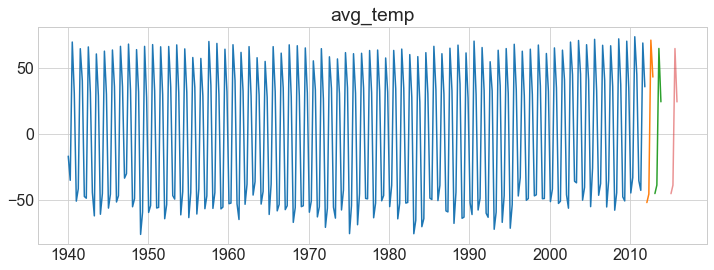

In [132]:
for col in train.columns:
    final_plot(col)